# Chapter 12 Short-term Reversal

### Introduction
* Definition: Stock returns over the short-term past tend to have a negative cross-sectional relation with returns over the next week or month.
* Measure: The short-term reversal of stock i for month t is taken simply to be the return of the stock during the month t, i.e. Rev_i,t = 100*R_i,t

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as mtick
import matplotlib.dates as mdate
from scipy.stats.mstats import winsorize
import statsmodels.formula.api as smf

C:\Users\asus\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('monthly.csv')
df = df[(df['type']!=2)&(df['type']!=8)].iloc[:,:-1]
df['Rev'] = df['rt']*100 # Measuring Short-Term reversal
df['mktcap'] /= 1000  # calculate in millions
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['month_num'] = (df['year']-2000)*12+df['month']
df['size'] = np.log(df.mktcap)
# 将以前计算得到的因子读进df, 一起进行样本筛选
beta = pd.read_csv('beta.csv',index_col=0).iloc[:,25:]
beta.columns=range(1,241)
Mom = pd.read_csv('Mom.csv',index_col=0)
Mom.columns=range(1,241)
bm = pd.read_csv('bm.csv',index_col=0).iloc[:,21:]
valid = [x for x in bm.index if x in Mom.index]
bm = bm.loc[valid]
bm.columns=range(1,241)
beta2 = beta.stack().reset_index()
beta2.columns = ['code','month_num','beta']
bm2 = bm.stack().reset_index()
bm2.columns = ['code','month_num','bm']
Mom2 = Mom.stack().reset_index()
Mom2.columns = ['code','month_num','Mom']
df=pd.merge(df,beta2,on=['code','month_num'],how='left')
df=pd.merge(df,bm2,on=['code','month_num'],how='left')
df=pd.merge(df,Mom2,on=['code','month_num'],how='left')

In [3]:
# 样本筛选, 剔除每期30%小市值和上市不满半年的股票
def newdf(df):
    newdf = pd.DataFrame()
    for i in range(-11,241):
        temp1 = df[df['month_num']==i]['mktcap'].quantile(.30)
        temp2 = df[(df['month_num']==i)&(df['mktcap']>=temp1)]
        valid = [x for x in df[df['month_num']==i]['code'].values  if x in df[df['month_num']==i-6]['code'].values]
        temp2[temp2['code'].isin(valid)]
        newdf = pd.concat([newdf,temp2],axis=0)
#        print(i)
    return newdf
df = newdf(df)

In [4]:
# rf
rf=pd.read_csv('F-F_Factor.csv',usecols=['date','RF'])
Mkt_RF=pd.read_csv('F-F_Factor.csv',index_col=0, usecols=['date','Mkt_RF'])
Mkt_RF.index=pd.to_datetime(Mkt_RF.index)
Mkt_RF=Mkt_RF[(Mkt_RF.index < '2020-1-1') & (Mkt_RF.index > '1999-12-31')]
Mkt_RF.index=range(1,241)
# rt_rf
rf['date']=pd.to_datetime(rf['date'])
rf['year']=rf['date'].dt.year
rf['month']=rf['date'].dt.month
rf=rf.drop(['date'],axis=1)
df=pd.merge(df,rf,on=['year','month'])
df['rt_rf']=df['rt']*100-df['RF']
# one year ahead rt_rf 
rt_rf = pd.pivot_table(df,index=['code'],values=['rt_rf'],columns=['date']).iloc[:,12:]
rt_rf.columns=range(1,241)
rt_rf.columns = rt_rf.columns-1
rt_rf = rt_rf.loc[:,1:]
# FF4 factors
ffc=pd.read_csv('fivefactor_monthly.csv', usecols=['date','mkt_rf','smb','hml','mom'])
ffc['year'] = ffc['date']//100
ffc['month'] = ffc['date']%100
ffc = ffc[(ffc['year']>=2000)&(ffc['year']<=2019)]
ffc['month_num'] = (ffc['year']-2000)*12+ffc['month']
ffc.index = ffc['month_num']
ffc = ffc[['mkt_rf','smb','hml','mom']]
ffc.columns = ['Mkt_RF','SMB','HML','MOM']

In [5]:
# beta, Mom, size, bm, mktcap (for Table1-5)
bm = pd.pivot_table(df,index=['code'],values=['bm'],columns=['date'])
bm.columns=range(1,241)
beta = pd.pivot_table(df,index=['code'],values=['beta'],columns=['date'])
beta.columns=range(1,241)
Mom = pd.pivot_table(df,index=['code'],values=['Mom'],columns=['date'])
Mom.columns=range(1,241)
size = pd.pivot_table(df,index=['code'],values=['size'],columns=['date']).iloc[:,12:]
size.columns=range(1,241)
Rev = pd.pivot_table(df,index=['code'],values=['Rev'],columns=['date']).iloc[:,12:]
Rev.columns=range(1,241)
mktcap = pd.pivot_table(df,index=['code'],values=['mktcap'],columns=['date']).iloc[:,12:]
mktcap.columns=range(1,241)

In [6]:
# Rev2, beta2, Mom2, size2, bm2, mktcap2, rt_rf2 (for Table6-9)
Rev2 = Rev.stack().reset_index()
Rev2.columns = ['code','month_num','Rev']
beta2 = beta.stack().reset_index()
beta2.columns = ['code','month_num','beta']
bm2 = bm.stack().reset_index()
bm2.columns = ['code','month_num','bm2']
Mom2 = Mom.stack().reset_index()
Mom2.columns = ['code','month_num','Mom2']
mktcap2 = mktcap.stack().reset_index()
mktcap2.columns = ['code','month_num','mktcap']
rt_rf2 = rt_rf.stack().reset_index()
rt_rf2.columns = ['code','month_num','rt_rf']

### Summary Statistics

In [7]:
# Table1
def Rev_statistic(df,columnsame): 
    result = pd.DataFrame(index=list(range(1,241)),columns=['Mean','SD','Skew','Kurt','Min','5%','25%','Median','75%','95%','Max','n'])
    i = 0;
    for year in range(2000,2020):    
        for month in range(1,13):
            temp=df[(df['year']==year)&(df['month']==month)]['Rev']
            result.iloc[i,:] = [temp.mean(),temp.std(),temp.skew(),temp.kurt(),temp.min(),temp.quantile(.05),temp.quantile(.25),temp.median(),temp.quantile(.75),temp.quantile(.95),temp.max(),temp.count()]
            i=i+1
    return result
statistic=Rev_statistic(df,'Rev').applymap(lambda x:round(x, 2))
Table1 = pd.DataFrame(statistic.mean(axis=0).values.reshape(1,12), index = ['Rev'], columns=['Mean','SD','Skew','Kurt','Min','5%','25%','Median','75%','95%','Max','n'])
Table1['n'] = Table1['n'].astype('int')

In [9]:
Table1.applymap(lambda x:round(x, 2))

,Mean,SD,Skew,Kurt,Min,5%,25%,Median,75%,95%,Max,n
Rev,1.82,11.46,2.89,54.11,-34.67,-11.71,-4.51,0.35,6.44,19.7,138.52,1380


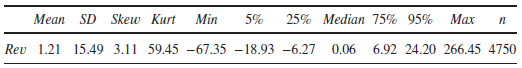

### Correlations

In [14]:
def correlation(a, b, c, d, e):
    i, j = [0, 0, 0, 0], [0, 0, 0, 0]
    for t in range(240):
            temp = pd.DataFrame(data=[a.iloc[:,t].values,b.iloc[:,t].values,c.iloc[:,t].values,d.iloc[:,t].values,e.iloc[:,t].values]).T
    i, j = np.sum([i,temp.corr('pearson').iloc[0,1:5]], axis = 0), np.sum([j,temp.corr('spearman').iloc[0,1:5]], axis = 0)
    return i/240, j/240
row1, row2 = correlation(Rev, beta, size, bm, Mom)
Table2 = pd.DataFrame(data=[row1,row2],index=['Pearson','Spearman'],columns=['beta', 'size', 'BM', 'Mom'])

In [15]:
Table2.applymap(lambda x:round(x, 6))

,beta,size,BM,Mom
Pearson,0.000704,0.000075,-0.000282,-0.000074
Spearman,0.000960,0.000190,-0.000564,0.000175


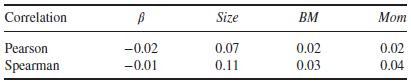

### Univariate Portfolio Analysis
* the relation between reversal and future stock returns

In [17]:
# Table3
# Table3A
def factor_portfolio(factor,list_of_data,list_of_data_name):
    avg_list = pd.DataFrame()
    for k in range(len(list_of_data)):
        data = list_of_data[k]
        data_name = list_of_data_name[k]
        data_list = pd.DataFrame()
        for i in factor.columns:
            temp_factor = factor[i].dropna()
            temp_data = data[i].dropna()
            x = pd.concat([temp_factor,temp_data],axis=1)
            x.columns = [i,data_name]
            x['group'] = pd.qcut(x[i],10,labels=False)
            data_avg_i = x.groupby('group')[data_name].mean()
            data_list = pd.concat([data_list,data_avg_i],axis=1)
        data_list.columns = factor.columns
        data_list = data_list.T
        data_list.columns = range(1,11)
        data_avg = data_list.mean()
        data_avg.name = data_name
        avg_list = pd.concat([avg_list,data_avg],axis=1)
    data_count_list = pd.DataFrame()
    for i in factor.columns:
        temp_factor = factor[i].dropna()
        x = pd.qcut(temp_factor,10,labels=False)
        x = pd.concat([temp_factor,x],axis=1,keys=['factor','group'])
        data_count_i = x.groupby('group')['factor'].count()
        data_count_list = pd.concat([data_count_list,data_count_i],axis=1)
    data_count_list = data_count_list.T
    data_count_list.columns = range(1,11)
    data_count = data_count_list.mean()
    data_count.name = 'n'
    avg_list = pd.concat([avg_list,data_count],axis=1)
    avg_list = avg_list.T
    return avg_list

Table3_A = factor_portfolio(Rev,[Rev,beta,mktcap,bm,Mom],['Rev','beta','MktCap','BM','Mom'])
Table3_A

,1,2,3,4,5,6,7,8,9,10
Rev,-13.033082,-7.146012,-4.533725,-2.478483,-0.594146,1.360460,3.618704,6.494862,10.804819,23.708803
beta,1.085866,1.096071,1.092128,1.089729,1.082947,1.075540,1.069978,1.062985,1.060618,1.075737
MktCap,8925.339410,8357.160002,7815.441067,7817.617306,8015.415125,8830.851640,9291.912098,9852.779757,9056.687550,9013.598998
BM,0.781760,0.858300,0.885286,0.898196,0.895655,0.881255,0.841168,0.810231,0.743461,0.651460
Mom,38.896499,23.904359,18.908997,16.484245,15.188297,15.952141,17.245892,19.534979,22.074592,26.978366
n,138.537500,138.045833,137.995833,137.979167,138.170833,137.795833,138.004167,137.991667,137.925000,138.383333


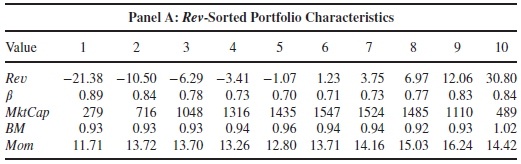

In [18]:
# Table3B
def Table3Bfun(factor,rt,ffc):
    rt_list = pd.DataFrame()
    for i in rt.columns:
        temp_factor = factor[i]
        temp_rt = rt[i]
        x = pd.concat([temp_factor,temp_rt],axis=1)
        x.columns = ['factor','rt']
        x = x.dropna()
        x['group'] = pd.qcut(x['factor'],10,labels=False)
        rt_avg_i = x.groupby('group')['rt'].mean()
        rt_list = pd.concat([rt_list,rt_avg_i],axis=1)
    rt_list.columns = rt.columns
    rt_list = rt_list.T
    rt_list.columns = range(1,11)
    rt_list['10-1'] = rt_list[10] - rt_list[1]
    avg_t = []
    CAPMalpha = []
    CAPMalpha_t = []
    FFalpha = []
    FFalpha_t = []
    FFCalpha = []
    FFCalpha_t = []
    for j in rt_list.columns:
        model = sm.OLS(rt_list[j],[1]*len(rt_list[j]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        reg_list = pd.concat([rt_list[j],ffc],axis=1,join='inner')
        reg_list.columns = ['rt','a','b','c','d']
        model0 = smf.ols('rt~a',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        CAPMalpha.append(model0.params[0])
        CAPMalpha_t.append(model0.tvalues[0])
        model1 = smf.ols('rt~a+b+c',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFalpha.append(model1.params[0])
        FFalpha_t.append(model1.tvalues[0])
        model2 = smf.ols('rt~a+b+c+d',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = rt_list.mean()
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    CAPMalpha = pd.Series(CAPMalpha,index = rt_avg.index)
    CAPMalpha_t = pd.Series(CAPMalpha_t,index = rt_avg.index)
    FFalpha = pd.Series(FFalpha,index = rt_avg.index)
    FFalpha_t = pd.Series(FFalpha_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    X = pd.concat([rt_avg,avg_t,CAPMalpha,CAPMalpha_t,FFalpha,FFalpha_t,FFCalpha,FFCalpha_t],axis=1).T
    X.index = ['Excess return',' ','CAPM α',' ','FF α',' ','FFC α',' ']
    return X

Table3_B = Table3Bfun(Rev,rt_rf,ffc)
Table3_B

,1,2,3,4,5,6,7,8,9,10,10-1
Excess return,1.451967,1.552414,1.487234,1.307624,1.397244,1.228259,1.072446,0.865690,0.766027,0.394063,-1.057904
,2.045889,2.129335,2.075032,1.749889,1.847116,1.623119,1.413789,1.201433,1.008945,0.525321,-3.781019
CAPM α,1.487763,1.595156,1.533781,1.341198,1.429505,1.263890,1.108559,0.898465,0.780309,0.411459,-1.076304
,2.063528,2.150209,2.100079,1.764593,1.860981,1.641738,1.430805,1.221111,1.009673,0.541191,-3.810765
FF α,1.596998,1.705378,1.646013,1.455497,1.532788,1.372355,1.208261,0.997008,0.874924,0.492103,-1.104895
,2.267302,2.344351,2.302280,1.948585,2.020260,1.804892,1.574941,1.369957,1.139648,0.646766,-3.919164
FFC α,1.281186,1.331673,1.301456,1.075162,1.171611,1.077243,0.907928,0.727578,0.542481,0.214342,-1.066844
,1.879639,1.908798,1.913328,1.551181,1.656481,1.491693,1.309292,1.080360,0.795219,0.312054,-4.322396


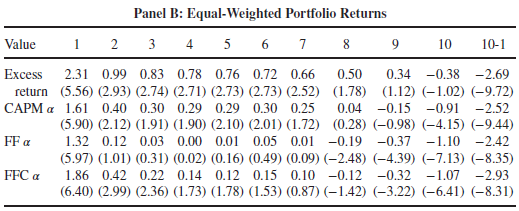

In [19]:
# Table3C
def Table3Cfun(factor,rt,mkt,ffc):
    rt_list = pd.DataFrame()
    for i in rt.columns:
        temp_factor = factor[i]
        temp_rt = rt[i]
        temp_mkt = mkt[i]
        x = pd.concat([temp_factor,temp_rt,temp_mkt],axis=1)
        x.columns = ['factor','rt','mktcap']
        x['rt*mkt'] = x['rt']*x['mktcap']
        x = x.dropna()
        x['group'] = pd.qcut(temp_factor,10,labels=False)
        rt_avg_i = x.groupby('group')['rt*mkt'].sum()/x.groupby('group')['mktcap'].sum()
        rt_list = pd.concat([rt_list,rt_avg_i],axis=1)
    rt_list.columns = rt.columns
    rt_list = rt_list.T
    rt_list.columns = range(1,11)
    rt_list['10-1'] = rt_list[10] - rt_list[1]
    avg_t = []
    avg_t = []
    CAPMalpha = []
    CAPMalpha_t = []
    FFalpha = []
    FFalpha_t = []
    FFCalpha = []
    FFCalpha_t = []
    for j in rt_list.columns:
        model = sm.OLS(rt_list[j],[1]*len(rt_list[j]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        reg_list = pd.concat([rt_list[j],ffc],axis=1,join='inner')
        reg_list.columns = ['rt','a','b','c','d']
        model0 = smf.ols('rt~a',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        CAPMalpha.append(model0.params[0])
        CAPMalpha_t.append(model0.tvalues[0])
        model1 = smf.ols('rt~a+b+c',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFalpha.append(model1.params[0])
        FFalpha_t.append(model1.tvalues[0])
        model2 = smf.ols('rt~a+b+c+d',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = rt_list.mean()
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    CAPMalpha = pd.Series(CAPMalpha,index = rt_avg.index)
    CAPMalpha_t = pd.Series(CAPMalpha_t,index = rt_avg.index)
    FFalpha = pd.Series(FFalpha,index = rt_avg.index)
    FFalpha_t = pd.Series(FFalpha_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    X = pd.concat([rt_avg,avg_t,CAPMalpha,CAPMalpha_t,FFalpha,FFalpha_t,FFCalpha,FFCalpha_t],axis=1).T
    X.index = ['Excess return',' ','CAPM α',' ','FF α',' ','FFC α',' ']
    return X     

Table3_C = Table3Cfun(Rev,rt_rf,mktcap,ffc)
Table3_C 

,1,2,3,4,5,6,7,8,9,10,10-1
Excess return,1.079738,1.052622,1.085354,0.796846,1.050328,0.884855,1.019915,0.917448,0.725138,0.178225,-0.901513
,1.623300,1.614805,1.627242,1.216155,1.481074,1.201728,1.471525,1.275763,0.943948,0.222759,-2.183728
CAPM α,1.108783,1.075677,1.104564,0.803228,1.073327,0.905093,1.044716,0.949071,0.724889,0.181763,-0.927020
,1.639727,1.630603,1.635085,1.215467,1.491889,1.216306,1.477824,1.298627,0.935107,0.226459,-2.289872
FF α,1.205895,1.159855,1.197409,0.902850,1.153658,1.009240,1.131730,1.056163,0.829256,0.279839,-0.926055
,1.817744,1.785756,1.808362,1.390624,1.621508,1.371615,1.625460,1.466159,1.074187,0.347389,-2.207534
FFC α,0.969331,0.938841,0.934920,0.672182,0.879848,0.743001,0.810226,0.779224,0.531107,0.080777,-0.888554
,1.557922,1.563784,1.511351,1.159540,1.412314,1.154286,1.363352,1.286667,0.810662,0.113997,-2.177170


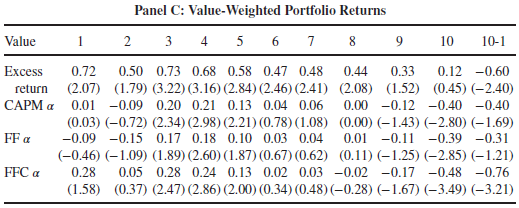

### Conclusion
* The excess returns indicate a strong negative relation between Rev and future stock returns.
* Adjusting the returns of the portfolios for risk does little to explain the patterns in average excess returns.
* The reversal phenomenon is driven by stocks with both high and low values of Rev(the positive alphas of decile portfolio 1 and negative alphas of decile portfolio 10 are large and highly statistically significant).
* Value-weighted portfolios detecting a much weaker reversal phenomenon than equal-weighted portfolios.

### Univariate Portfolio Analysis
* Lagged Values of Reversal: the relation between previous values of reversal and future stock returns.

In [20]:
# Table4
# Table4_A
def Table4A(factorname,factor,rt,ffc):
    rt_list = pd.DataFrame()
    for i in rt.columns:
        temp_factor = factor[i]
        temp_rt = rt[i]
        x = pd.concat([temp_factor,temp_rt],axis=1)
        x.columns = ['factor','rt']
        x = x.dropna()
        x['group'] = pd.qcut(x['factor'],10,labels=False)
        rt_avg_i = x.groupby('group')['rt'].mean()
        rt_list = pd.concat([rt_list,rt_avg_i],axis=1)
    rt_list.columns = rt.columns
    rt_list = rt_list.T
    rt_list.columns = range(1,11)
    rt_list['10-1'] = rt_list[10] - rt_list[1]
    t = [' ',' ',' ',' ',' ',' ',' ',' ',' ',' ']
    j = '10-1'
    model = sm.OLS(rt_list[j],[1]*len(rt_list[j]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
    t.append(model.tvalues[0])
    reg_list = pd.concat([rt_list[j],ffc],axis=1,join='inner')
    reg_list.columns = ['rt','a','b','c','d']
    model1 = smf.ols('rt~a+b+c',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
    rt_list['FF α']=model1.params[0]
    t.append(model1.tvalues[0])
    model2 = smf.ols('rt~a+b+c+d',reg_list, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
    rt_list['FFC α']=model2.params[0]
    t.append(model2.tvalues[0])

    rt_avg = rt_list.mean()
    t = pd.Series(t,index = rt_avg.index)
    X = pd.concat([rt_avg,t],axis=1).T
    X.index = [factorname,' ']
    return X

* The reversal phenomenon quickly becomes a momentum phenomenon——the average monthly returns are all positive and, in most cases, statistically significant.
* The reversal phenomenon is a very short-term effect.

In [22]:
# compute Lagged Values of Reversal and plot Table4_A
rt = pd.pivot_table(df,index=['code'],values=['rt'],columns=['month_num'])*100
rt.columns=range(-11,241)
Table4_A = Table4A('Rev',Rev,rt_rf,ffc)
for i in ['Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11']:
    rt.columns = rt.columns+1
    temp = Table4A(i,rt.loc[:,1:241],rt_rf,ffc)
    Table4_A = pd.concat([Table4_A,temp])
Table4_A

,1,2,3,4,5,6,7,8,9,10,10-1,FF α,FFC α
Rev,1.45197,1.55241,1.48723,1.30762,1.39724,1.22826,1.07245,0.86569,0.766027,0.394063,-1.0579,-1.1049,-1.06684
,,,,,,,,,,,-3.78102,-3.91916,-4.3224
Rt-1,1.25503,1.29434,1.29193,1.41579,1.23723,1.18064,1.28643,1.13285,0.893218,0.843722,-0.411308,-0.405381,-0.457343
,,,,,,,,,,,-1.72904,-1.65538,-1.78485
Rt-2,1.11485,1.09675,1.1543,1.2466,1.20799,1.30386,1.31481,1.22607,1.13047,1.22103,0.106187,0.0264667,0.101996
,,,,,,,,,,,0.32763,0.0856901,0.299503
Rt-3,0.984197,1.13076,1.22636,1.27814,1.20122,1.23257,1.33539,1.37517,1.34507,1.06732,0.0831183,0.0395961,0.208454
,,,,,,,,,,,0.314328,0.152235,0.891058
Rt-4,1.26236,1.41572,1.30316,1.20011,1.31447,1.30485,1.25958,1.06261,1.10228,0.931196,-0.331164,-0.378299,-0.286747
,,,,,,,,,,,-1.13619,-1.28483,-0.913151


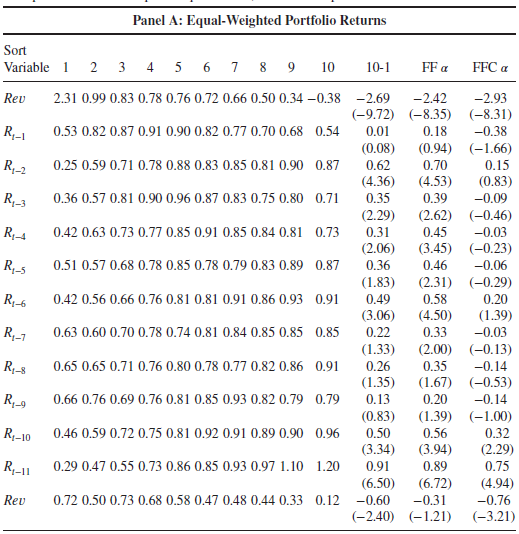

In [23]:
# Table4_B
def Table4B(factorname,factor,rt,mkt,ffc):
    rt_list = pd.DataFrame()
    for i in rt.columns:
        temp_factor = factor[i]
        temp_rt = rt[i]
        temp_mkt = mkt[i]
        x = pd.concat([temp_factor,temp_rt,temp_mkt],axis=1)
        x.columns = ['factor','rt','mktcap']
        x['rt*mkt'] = x['rt']*x['mktcap']
        x = x.dropna()
        x['group'] = pd.qcut(temp_factor,10,labels=False)
        rt_avg_i = x.groupby('group')['rt*mkt'].sum()/x.groupby('group')['mktcap'].sum()
        rt_list = pd.concat([rt_list,rt_avg_i],axis=1)
    rt_list.columns = rt.columns
    rt_list = rt_list.T
    rt_list.columns = range(1,11)
    rt_list['10-1'] = rt_list[10] - rt_list[1]
    t = [' ',' ',' ',' ',' ',' ',' ',' ',' ',' ']
    j = '10-1'
    model = sm.OLS(rt_list[j],[1]*len(rt_list[j]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
    t.append(model.tvalues[0])
    reg_list = pd.concat([rt_list[j],ffc],axis=1,join='inner')
    reg_list.columns = ['rt','a','b','c','d']
    model1 = smf.ols('rt~a+b+c+d',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
    rt_list['FF α']=model1.params[0]
    t.append(model1.tvalues[0])
    model2 = smf.ols('rt~a+b+c',reg_list, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
    rt_list['FFC α']=model2.params[0]
    t.append(model2.tvalues[0])
    rt_avg = rt_list.mean()
    t = pd.Series(t,index = rt_avg.index)
    X = pd.concat([rt_avg,t],axis=1).T
    X.index = [factorname,' ']
    return X

In [24]:
# compute Lagged Values of Reversal and plot Table4_B
rt = pd.pivot_table(df,index=['code'],values=['rt'],columns=['month_num'])*100
rt.columns=range(-11,241)
Table4_B = Table4B('Rev',Rev,rt_rf,mktcap,ffc)
for i in ['Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11']:
    rt.columns = rt.columns+1
    temp = Table4B(i,rt.loc[:,1:241],rt_rf,mktcap,ffc)
    Table4_B = pd.concat([Table4_B,temp])
Table4_B

,1,2,3,4,5,6,7,8,9,10,10-1,FF α,FFC α
Rev,1.07974,1.05262,1.08535,0.796846,1.05033,0.884855,1.01991,0.917448,0.725138,0.178225,-0.901513,-0.888554,-0.926055
,,,,,,,,,,,-2.18373,-2.17717,-2.20753
Rt-1,0.663361,0.876655,1.07573,1.1044,1.03075,0.943657,0.945834,0.772017,0.509455,0.352471,-0.31089,-0.279721,-0.267058
,,,,,,,,,,,-0.977498,-0.824486,-0.821239
Rt-2,0.717638,0.793219,0.767974,0.948253,0.639446,0.918061,0.776117,0.766826,0.642998,0.955004,0.237366,0.264595,0.113173
,,,,,,,,,,,0.516838,0.578778,0.262804
Rt-3,0.524735,0.782297,0.928755,0.834888,0.66286,0.534967,0.883185,1.04978,0.865561,0.603881,0.0791463,0.379745,0.01919
,,,,,,,,,,,0.226849,1.19233,0.0547171
Rt-4,0.73681,1.24491,1.08296,1.11682,1.10179,1.15048,0.954357,0.584262,0.532014,0.404539,-0.33227,-0.206466,-0.378518
,,,,,,,,,,,-0.809815,-0.494041,-0.933737


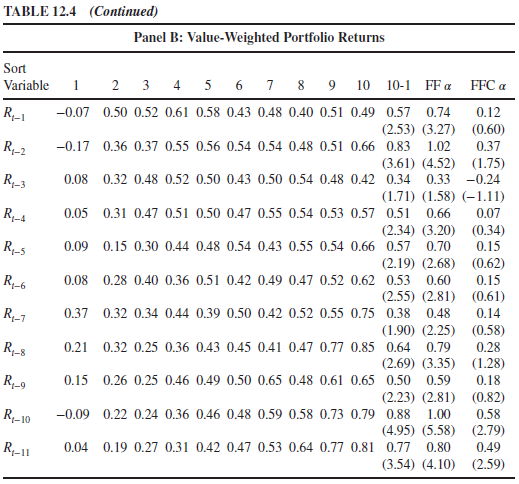

### Bivariate Dependent-Sort Portfolio Analysis—Control for MktCap
* the relation between Rev and future stock returns after controlling for the effect of MktCap

In [25]:
# Table5
def Table5fun(data1,data2,rt,ffc):
    # grouping
    X = pd.DataFrame()
    data = pd.merge(data1,data2,on=['code','month_num'])
    data = pd.merge(data,rt,on=['code','month_num'])
    data = data.dropna()
    data['rt_rf*mkt'] = data['rt_rf']*data['mktcap']
    data1_name = data1.columns[2]
    data2_name = data2.columns[2]
    for i in range(1,240):
        temp_value = data[data['month_num'] == i]
        temp_value['group1'] = pd.qcut(temp_value[data1_name],5,labels=False,duplicates='drop')
        x = pd.DataFrame()
        for j in range(5):
            temp_value2 = temp_value[temp_value['group1']==j]
            temp_value2['group2'] = pd.qcut(temp_value2[data2_name],5,labels=False,duplicates='drop')
            x = pd.concat([x,temp_value2],axis=0)
        X = pd.concat([X,x],axis=0)# panel data with group index
    temp1 = X.groupby(['month_num','group1','group2'])['rt_rf'].mean().reset_index()
    temp1 = pd.pivot_table(temp1,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    temp2 = (X.groupby(['month_num','group1','group2'])['rt_rf*mkt'].sum()/X.groupby(['month_num','group1','group2'])['mktcap'].sum()).reset_index()
    temp2 = temp2.rename(columns={0:'rt_rf'})
    temp2 = pd.pivot_table(temp2,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    tableWhole = pd.DataFrame()
    for temp in [temp1, temp2]:
        # avg and 5-1
        temp[5] = (temp[0]+temp[1]+temp[2]+temp[3]+temp[4])/5
        df = pd.DataFrame()
        for i in list(set(temp['month_num'])):
            x = temp[temp['month_num'] == i].reset_index(drop=True)
            x.loc[5,0:] = x.iloc[4,2:]-x.iloc[0,2:]
            x.iloc[5,:2] = [i,5]
            df = pd.concat([df,x],axis=0)
        df.reset_index(drop=True)
        # 计算所有组平均超额收益
        table = df.groupby('group2').mean().reset_index(drop=True)
        del table['month_num']
        # 计算所有data2分组内data1 5-1组值调整t检验以及CAPMα回归和调整t值
        avg_t = []
        CAPMalpha = []
        CAPMalpha_t = []
        FFalpha = []
        FFalpha_t = []
        FFCalpha = []
        FFCalpha_t = []
        temp = df[df['group2']==5]
        temp.index = temp['month_num']
        temp = pd.concat([temp,ffc],axis=1,join='inner')
        for i in range(6):
            model = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
            avg_t.append(model.tvalues[0])
            model1 = sm.OLS(temp[i],sm.add_constant(temp['Mkt_RF']), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
            CAPMalpha.append(model1.params[0])
            CAPMalpha_t.append(model1.tvalues[0])
            model2 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
            FFalpha.append(model2.params[0])
            FFalpha_t.append(model2.tvalues[0])
            model3 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML','MOM']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
            FFCalpha.append(model3.params[0])
            FFCalpha_t.append(model3.tvalues[0])
        avg_t = pd.Series(avg_t,index = range(6))
        CAPMalpha = pd.Series(CAPMalpha,index = range(6))
        CAPMalpha_t = pd.Series(CAPMalpha_t,index = range(6))
        FFalpha = pd.Series(FFalpha,index = range(6))
        FFalpha_t = pd.Series(FFalpha_t,index = range(6))
        FFCalpha = pd.Series(FFCalpha,index = range(6))
        FFCalpha_t = pd.Series(FFCalpha_t,index = range(6))
        extra_data1 = pd.concat([avg_t,CAPMalpha,CAPMalpha_t,FFalpha,FFalpha_t,FFCalpha,FFCalpha_t],axis=1).T
        tableWhole = pd.concat([tableWhole,table,extra_data1])
    return tableWhole

In [26]:
Table5 = Table5fun(mktcap2,Rev2,rt_rf2,ffc)
Table5.columns = [' Mktcap1   ',' Mktcap2   ',' Mktcap3   ',' Mktcap4   ',' Mktcap5   ',' Mktcap Avg   ']
Table5.index = ['Rev1 EW','Rev2 EW','Rev3 EW','Rev4 EW','Rev5 EW','Rev5-1 EW',' ','Rev5-1 CAPMα  EW',' ','Rev5-1 FFα  EW',' ','Rev5-1 FFCα  EW',' ',\
                'Rev1 VW','Rev2 VW','Rev3 VW','Rev4 VW','Rev5 VW','Rev5-1 VW',' ','Rev5-1 CAPMα  VW',' ','Rev5-1 FFα  VW',' ','Rev5-1 FFCα  VW',' ']

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
Table5.applymap(lambda x:round(x, 2))

,Mktcap1,Mktcap2,Mktcap3,Mktcap4,Mktcap5,Mktcap Avg
Rev1 EW,2.90,1.42,1.53,1.15,0.77,1.55
Rev2 EW,2.66,1.48,1.07,1.06,0.86,1.43
Rev3 EW,2.46,1.23,1.17,0.79,0.83,1.30
Rev4 EW,2.14,0.73,0.58,0.40,0.72,0.91
Rev5 EW,2.18,0.14,-0.01,0.18,0.36,0.57
Rev5-1 EW,-0.72,-1.28,-1.54,-0.97,-0.41,-0.98
,-3.34,-5.01,-6.70,-3.29,-1.19,-4.54
Rev5-1 CAPMα EW,-0.74,-1.29,-1.58,-0.96,-0.42,-1.00
,-3.42,-5.05,-6.62,-3.25,-1.22,-4.54
Rev5-1 FFα EW,-0.77,-1.33,-1.62,-0.99,-0.42,-1.03


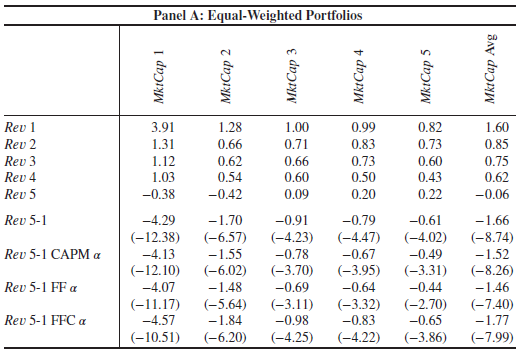

* The reversal phenomenon is strong in each quintile of market capitalization although it becomes stronger for smaller capitalization stocks.

### Bivariate Dependent-Sort Portfolio Analysis
* the relation between Rev and future stock returns after controlling for the effect of each of 𝛽, BM, and Mom (control variables)

In [28]:
# Table6
def Table6fun(control,other,rt,mkt,ffc):
    # grouping
    X = pd.DataFrame()
    data = pd.merge(control,other,on=['code','month_num'])
    data = pd.merge(data,rt,on=['code','month_num'])
    data = pd.merge(data,mkt,on=['code','month_num'])
    data = data.dropna()
    data['rt_rf*mkt'] = data['rt_rf']*data['mktcap']
    control_name = control.columns[2]
    other_name = other.columns[2]
    for i in range(1,240):
        temp_value = data[data['month_num'] == i]
        temp_value['group1'] = pd.qcut(temp_value[control_name],5,labels=False,duplicates='drop')
        x = pd.DataFrame()
        for j in range(5):
            temp_value2 = temp_value[temp_value['group1']==j]
            temp_value2['group2'] = pd.qcut(temp_value2[other_name],5,labels=False,duplicates='drop')
            x = pd.concat([x,temp_value2],axis=0)
        X = pd.concat([X,x],axis=0)# panel data with group index
    # 求每期每组市场等权均值
    temp_equal = X.groupby(['month_num','group1','group2'])['rt_rf'].mean().reset_index()
    temp_equal = pd.pivot_table(temp_equal,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    temp_equal[5] = (temp_equal[0]+temp_equal[1]+temp_equal[2]+temp_equal[3]+temp_equal[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_equal['month_num'])):
        x = temp_equal[temp_equal['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1)
    df = df.T
    df.index = list(set(temp_equal['month_num']))##df中index为月份，columns为组别
    # 回归与求t
    avg_t = []
    FFalpha = []
    FFalpha_t = []
    FFCalpha = []
    FFCalpha_t = []
    temp = pd.concat([df,ffc],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        model1 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFalpha.append(model1.params[0])
        FFalpha_t.append(model1.tvalues[0])
        model2 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML','MOM']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Control1','Control2','Control3','Control4','Control5','Control avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    FFalpha = pd.Series(FFalpha,index = rt_avg.index)
    FFalpha_t = pd.Series(FFalpha_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    EW = pd.concat([rt_avg,avg_t,FFalpha,FFalpha_t,FFCalpha,FFCalpha_t],axis=1).T
    EW.index = ['Return',' ','FF α',' ','FFC α',' ']    
    # 求每期每组市场加权均值
    temp_weight = (X.groupby(['month_num','group1','group2'])['rt_rf*mkt'].sum()/X.groupby(['month_num','group1','group2'])['mktcap'].sum()).reset_index()
    temp_weight = temp_weight.rename(columns={0:'rt_rf'})
    temp_weight = pd.pivot_table(temp_weight,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    temp_weight[5] = (temp_weight[0]+temp_weight[1]+temp_weight[2]+temp_weight[3]+temp_weight[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_weight['month_num'])):
        x = temp_weight[temp_weight['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1)
    df = df.T
    df.index = list(set(temp_weight['month_num']))# df中index为月份，columns为组别
    # 回归与求t
    avg_t = []
    FFalpha = []
    FFalpha_t = []
    FFCalpha = []
    FFCalpha_t = []
    temp = pd.concat([df,ffc],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        model1 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFalpha.append(model1.params[0])
        FFalpha_t.append(model1.tvalues[0])
        model2 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML','MOM']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Control1','Control2','Control3','Control4','Control5','Control avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    FFalpha = pd.Series(FFalpha,index = rt_avg.index)
    FFalpha_t = pd.Series(FFalpha_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    VW = pd.concat([rt_avg,avg_t,FFalpha,FFalpha_t,FFCalpha,FFCalpha_t],axis=1).T
    VW.index = ['Return',' ','FF α',' ','FFC α',' ']    
    table = pd.concat([EW,VW],keys=['EW','VW'])
    return table   

In [29]:
beta_rev = Table6fun(beta2,Rev2,rt_rf2,mktcap2,ffc)
bm_rev = Table6fun(bm2,Rev2,rt_rf2,mktcap2,ffc)
mom_rev = Table6fun(Mom2,Rev2,rt_rf2,mktcap2,ffc)
Table6 = pd.concat([beta_rev,bm_rev,mom_rev],keys=['beta','BM','Mom'])
Table6.applymap(lambda x:round(x, 2))

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Control1  Control2  Control3  Control4  Control5  Control avg
beta EW Return      0.21     -0.72     -1.02     -1.34     -1.71        -0.91
                    0.78     -2.75     -3.68     -4.70     -5.54        -4.00
        FF α        0.19     -0.76     -1.07     -1.42     -1.79        -0.97
                    0.66     -2.76     -3.88     -5.13     -5.95        -4.24
        FFC α       0.26     -0.76     -1.09     -1.28     -1.57        -0.89
                    0.91     -2.83     -4.83     -5.12     -6.18        -4.36
     VW Return      0.29     -0.49     -0.79     -1.21     -1.46        -0.73
                    0.63     -1.27     -2.35     -4.00     -4.28        -2.69
        FF α        0.29     -0.49     -0.79     -1.29     -1.55        -0.77
                    0.60     -1.21     -2.30     -4.42     -4.79        -2.78
        FFC α       0.26     -0.42     -0.79     -1.16     -1.48        -0.72
                    0.53     -1.07     -2.49     -3.90     -5.30        -2.66
BM   EW Return     -1.19     -0.90     -0.64     -1.12     -0.72        -0.91
                   -4.16     -2.91     -3.06     -4.63     -2.97        -4.48
        FF α       -1.25     -0.97     -0.67     -1.14     -0.72        -0.95
                   -4.48     -3.14     -3.28     -4.65     -2.92        -4.63
        FFC α      -1.14     -1.14     -0.63     -1.07     -0.68        -0.93
                   -4.28     -4.98     -3.07     -4.46     -2.94        -4.90
     VW Return     -0.89     -0.66     -0.44     -0.87     -0.38        -0.65
                   -1.97     -1.84     -1.30     -2.71     -1.22        -2.35
        FF α       -0.95     -0.70     -0.46     -0.89     -0.38        -0.68
                   -2.12     -1.89     -1.33     -2.66     -1.17        -2.36
        FFC α      -0.88     -0.86     -0.42     -0.97     -0.51        -0.73
                   -1.92     -2.35     -1.25     -3.05     -1.68        -2.61
Mom  EW Return     -1.28     -1.10     -1.00     -0.94     -0.75        -1.01
                   -4.73     -4.29     -3.96     -2.78     -2.31        -4.29
        FF α       -1.30     -1.13     -1.05     -1.03     -0.84        -1.07
                   -4.72     -4.43     -4.00     -3.13     -2.69        -4.49
        FFC α      -1.42     -1.11     -0.93     -0.80     -0.59        -0.97
                   -5.76     -4.57     -3.76     -2.54     -2.14        -4.39
     VW Return     -1.06     -1.05     -0.41     -0.68     -0.51        -0.74
                   -2.64     -3.02     -1.02     -1.65     -1.44        -2.47
        FF α       -1.02     -1.07     -0.41     -0.72     -0.61        -0.77
                   -2.50     -3.09     -0.99     -1.74     -1.72        -2.49
        FFC α      -1.23     -0.94     -0.60     -0.64     -0.33        -0.75
                   -3.28     -2.66     -1.47     -1.55     -0.98        -2.54

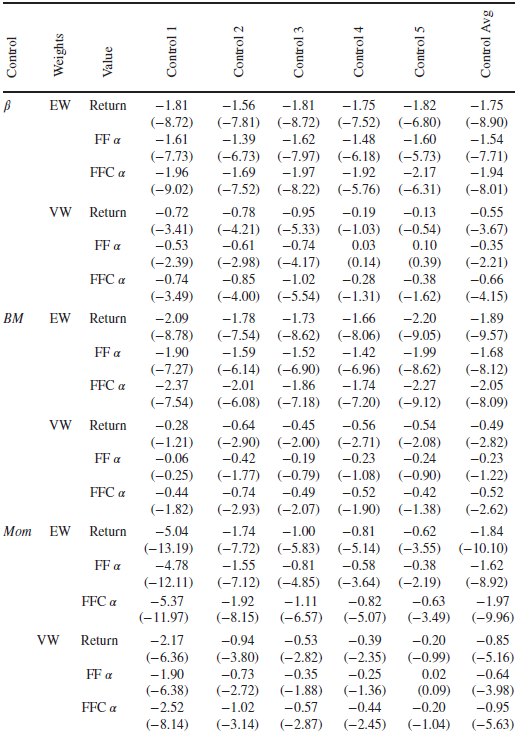

* The reversal phenomenon is not explained by the relation between beta and stock returns nor by the size, value, or momentum effects.

### Bivariate Independent-Sort Portfolio Analysis
* the relation between Rev and future stock returns after controlling for the effect of each of 𝛽, MktCap, BM, and Mom (control variables)

In [30]:
# Table7
def Table7fun(control,other,rt,mkt,ffc):
    # grouping
    X = pd.DataFrame()
    data = pd.merge(control,other,on=['code','month_num'])
    data = pd.merge(data,rt,on=['code','month_num'])
    if 'mktcap' in data.columns:
        data = data.drop('mktcap',axis=1)
    data = pd.merge(data,mkt,on=['code','month_num'])
    data = data.dropna()
    data['rt_rf*mkt'] = data['rt_rf']*data['mktcap']
    control_name = control.columns[2]
    other_name = other.columns[2]
    for i in range(1,240):
        temp_value = data[data['month_num'] == i]
        temp_value['group1'] = pd.qcut(temp_value[control_name],5,labels=False,duplicates='drop')
        temp_value['group2'] = pd.qcut(temp_value[other_name],5,labels=False,duplicates='drop')
        X = pd.concat([X,temp_value],axis=0)# panel data with group index
    # 求每期每组市场等权均值
    temp_equal = X.groupby(['month_num','group1','group2'])['rt_rf'].mean().reset_index()
    temp_equal = pd.pivot_table(temp_equal,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    temp_equal[5] = (temp_equal[0]+temp_equal[1]+temp_equal[2]+temp_equal[3]+temp_equal[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_equal['month_num'])):
        x = temp_equal[temp_equal['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1)
    df = df.T
    df.index = list(set(temp_equal['month_num']))# df中index为月份，columns为组别
    # 回归与求t
    avg_t = []
    FFalpha = []
    FFalpha_t = []
    FFCalpha = []
    FFCalpha_t = []
    temp = pd.concat([df,ffc],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        model1 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFalpha.append(model1.params[0])
        FFalpha_t.append(model1.tvalues[0])
        model2 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML','MOM']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Control1','Control2','Control3','Control4','Control5','Control avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    FFalpha = pd.Series(FFalpha,index = rt_avg.index)
    FFalpha_t = pd.Series(FFalpha_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    EW = pd.concat([rt_avg,avg_t,FFalpha,FFalpha_t,FFCalpha,FFCalpha_t],axis=1).T
    EW.index = ['Return',' ','FF α',' ','FFC α',' ']    
    # 求每期每组市场加权均值
    temp_weight = (X.groupby(['month_num','group1','group2'])['rt_rf*mkt'].sum()/X.groupby(['month_num','group1','group2'])['mktcap'].sum()).reset_index()
    temp_weight = temp_weight.rename(columns={0:'rt_rf'})
    temp_weight = pd.pivot_table(temp_weight,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    temp_weight[5] = (temp_weight[0]+temp_weight[1]+temp_weight[2]+temp_weight[3]+temp_weight[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_weight['month_num'])):
        x = temp_weight[temp_weight['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1)
    df = df.T
    df.index = list(set(temp_weight['month_num']))# df中index为月份，columns为组别
    # 回归与求t
    avg_t = []
    FFalpha = []
    FFalpha_t = []
    FFCalpha = []
    FFCalpha_t = []
    temp = pd.concat([df,ffc],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        model1 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFalpha.append(model1.params[0])
        FFalpha_t.append(model1.tvalues[0])
        model2 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML','MOM']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Control1','Control2','Control3','Control4','Control5','Control avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    FFalpha = pd.Series(FFalpha,index = rt_avg.index)
    FFalpha_t = pd.Series(FFalpha_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    VW = pd.concat([rt_avg,avg_t,FFalpha,FFalpha_t,FFCalpha,FFCalpha_t],axis=1).T
    VW.index = ['Return',' ','FF α',' ','FFC α',' ']    
    table = pd.concat([EW,VW],keys=['EW','VW'])
    return table

In [31]:
beta_rev = Table7fun(beta2,Rev2,rt_rf2,mktcap2,ffc)
mktcap2_rev = Table7fun(mktcap2,Rev2,rt_rf2,mktcap2,ffc)
bm_rev = Table7fun(bm2,Rev2,rt_rf2,mktcap2,ffc)
mom_rev = Table7fun(Mom2,Rev2,rt_rf2,mktcap2,ffc)
Table7 = pd.concat([beta_rev,mktcap2_rev,bm_rev,mom_rev],keys=['beta','Mktcap','BM','Mom'])
Table7.applymap(lambda x:round(x, 2))

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Control1  Control2  Control3  Control4  Control5  \
beta   EW Return      0.25     -0.75     -0.89     -1.27     -1.59   
                      0.89     -2.76     -3.05     -4.31     -4.71   
          FF α        0.23     -0.78     -0.95     -1.37     -1.67   
                      0.79     -2.77     -3.22     -4.94     -5.13   
          FFC α       0.36     -0.77     -0.99     -1.20     -1.49   
                      1.16     -2.78     -4.37     -4.66     -5.22   
       VW Return      0.66     -0.57     -0.64     -1.11     -1.38   
                      1.42     -1.42     -1.79     -3.61     -3.46   
          FF α        0.66     -0.56     -0.65     -1.20     -1.50   
                      1.38     -1.35     -1.78     -4.11     -3.97   
          FFC α       0.60     -0.47     -0.67     -1.03     -1.46   
                      1.19     -1.14     -2.12     -3.47     -4.57   
Mktcap EW Return     -0.47     -1.24     -1.44     -0.99     -0.56   
                     -1.83     -4.95     -6.41     -3.49     -1.56   
          FF α       -0.52     -1.30     -1.52     -1.01     -0.57   
                     -2.01     -5.41     -6.97     -3.59     -1.56   
          FFC α      -0.62     -1.23     -1.40     -0.95     -0.52   
                     -3.01     -5.46     -6.30     -3.43     -1.57   
       VW Return     -0.56     -1.24     -1.43     -0.97     -0.38   
                     -2.26     -4.90     -6.36     -3.40     -1.00   
          FF α       -0.61     -1.31     -1.50     -0.99     -0.38   
                     -2.45     -5.40     -6.89     -3.48     -0.98   
          FFC α      -0.71     -1.23     -1.38     -0.94     -0.38   
                     -3.46     -5.38     -6.17     -3.38     -0.97   
BM     EW Return     -1.11     -0.91     -0.58     -1.25     -0.95   
                     -4.23     -2.91     -2.53     -4.91     -3.09   
          FF α       -1.18     -0.99     -0.62     -1.29     -0.97   
                     -4.49     -3.16     -2.83     -5.06     -3.05   
          FFC α      -1.08     -1.10     -0.58     -1.22     -0.95   
                     -4.07     -4.81     -2.59     -4.65     -3.27   
       VW Return     -0.80     -0.58     -0.39     -1.04     -0.56   
                     -2.03     -1.72     -1.11     -2.81     -1.42   
          FF α       -0.86     -0.62     -0.43     -1.06     -0.56   
                     -2.17     -1.82     -1.21     -2.75     -1.37   
          FFC α      -0.76     -0.76     -0.39     -1.13     -0.78   
                     -1.85     -2.18     -1.14     -3.01     -2.11   
Mom    EW Return     -1.25     -0.97     -1.08     -0.94     -0.86   
                     -3.73     -3.41     -4.25     -2.79     -2.78   
          FF α       -1.32     -1.01     -1.13     -1.02     -0.95   
                     -4.01     -3.58     -4.33     -3.10     -3.16   
          FFC α      -1.39     -1.01     -1.01     -0.79     -0.74   
                     -4.81     -3.93     -3.98     -2.49     -2.75   
       VW Return     -1.04     -0.91     -0.54     -0.57     -0.63   
                     -2.38     -2.42     -1.37     -1.46     -1.82   
          FF α       -1.06     -0.93     -0.54     -0.59     -0.72   
                     -2.39     -2.47     -1.33     -1.50     -2.09   
          FFC α      -1.27     -0.85     -0.75     -0.49     -0.43   
                     -3.17     -2.23     -1.91     -1.31     -1.37   

                  Control avg  
beta   EW Return        -0.85  
                        -3.61  
          FF α          -0.90  
                        -3.87  
          FFC α         -0.81  
                        -3.82  
       VW Return        -0.60  
                        -2.15  
          FF α          -0.65  
                        -2.26  
          FFC α         -0.60  
                        -2.17  
Mktcap EW Return        -0.94  
                        -4.33  
          FF α          -0.98  
                        -4.57  
          FFC α         -0.94  
           

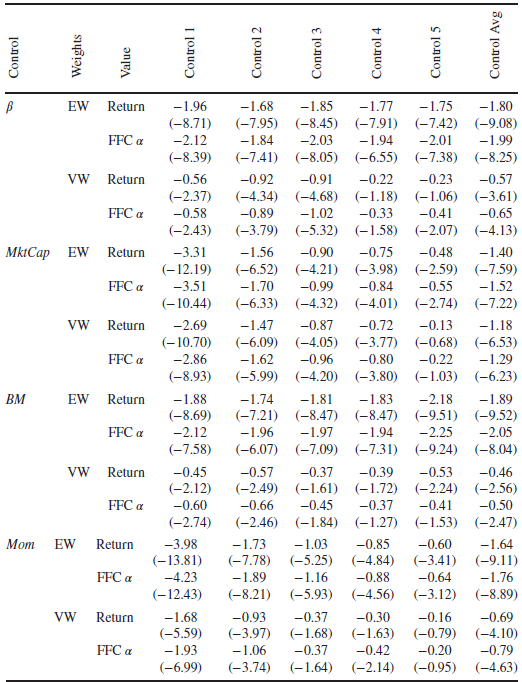

### Bivariate Dependent-Sort Portfolio Analysis—Control for Rev
* Whether the reversal phenomenon can explain any of these patterns in expected returns that have been documented in previous chapters? 
* the relation between future stock returns and each of 𝛽, MktCap, BM, and Mom (second sort variables) after controlling for the effect of Rev.

In [32]:
# Table8
def Table8fun(other,sort,rt,mkt,ffc):
    # grouping
    X = pd.DataFrame()
    data = pd.merge(other,sort,on=['code','month_num'])
    data = pd.merge(data,rt,on=['code','month_num'])
    if 'mktcap' in data.columns:
        data = data.drop('mktcap',axis=1)
    data = pd.merge(data,mkt,on=['code','month_num'])
    data = data.dropna()
    data['rt_rf*mkt'] = data['rt_rf']*data['mktcap']
    other_name = other.columns[2]
    sort_name = sort.columns[2]
    for i in range(1,240):
        temp_value = data[data['month_num'] == i]
        temp_value['group1'] = pd.qcut(temp_value[other_name],5,labels=False,duplicates='drop')
        x = pd.DataFrame()
        for j in range(5):
            temp_value2 = temp_value[temp_value['group1']==j]
            temp_value2['group2'] = pd.qcut(temp_value2[sort_name],5,labels=False,duplicates='drop')
            x = pd.concat([x,temp_value2],axis=0)
        X = pd.concat([X,x],axis=0)# panel data with group index
    # 求每期每组市场等权均值
    temp_equal = X.groupby(['month_num','group1','group2'])['rt_rf'].mean().reset_index()
    temp_equal = pd.pivot_table(temp_equal,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    temp_equal[5] = (temp_equal[0]+temp_equal[1]+temp_equal[2]+temp_equal[3]+temp_equal[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_equal['month_num'])):
        x = temp_equal[temp_equal['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1)
    df = df.T
    df.index = list(set(temp_equal['month_num']))##df中index为月份，columns为组别
    # 回归与求t
    avg_t = []
    FFCalpha = []
    FFCalpha_t = []
    temp = pd.concat([df,ffc],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML','MOM']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Rev1','Rev2','Rev3','Rev4','Rev5','Rev avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    
    EW = pd.concat([rt_avg,avg_t,FFCalpha,FFCalpha_t],axis=1).T
    EW.index = ['Return',' ','FFC α',' ']    
    # 求每期每组市场加权均值
    temp_weight = (X.groupby(['month_num','group1','group2'])['rt_rf*mkt'].sum()/X.groupby(['month_num','group1','group2'])['mktcap'].sum()).reset_index()
    temp_weight = temp_weight.rename(columns={0:'rt_rf'})
    temp_weight = pd.pivot_table(temp_weight,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    temp_weight[5] = (temp_weight[0]+temp_weight[1]+temp_weight[2]+temp_weight[3]+temp_weight[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_weight['month_num'])):
        x = temp_weight[temp_weight['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1)
    df = df.T
    df.index = list(set(temp_weight['month_num']))# df中index为月份，columns为组别
    #回归与求t
    avg_t = []
    FFCalpha = []
    FFCalpha_t = []
    temp = pd.concat([df,ffc],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML','MOM']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Rev1','Rev2','Rev3','Rev4','Rev5','Rev avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    
    VW = pd.concat([rt_avg,avg_t,FFCalpha,FFCalpha_t],axis=1).T
    VW.index = ['Return',' ','FFC α',' ']    
    table = pd.concat([EW,VW],keys=['EW','VW'])
    return table

In [33]:
rev_beta = Table8fun(Rev2,beta2,rt_rf2,mktcap2,ffc)
rev_mktcap = Table8fun(Rev2,mktcap2,rt_rf2,mktcap2,ffc)
rev_bm = Table8fun(Rev2,bm2,rt_rf2,mktcap2,ffc)
rev_mom = Table8fun(Rev2,Mom2,rt_rf2,mktcap2,ffc)
Table8 = pd.concat([rev_beta,rev_mktcap,rev_bm,rev_mom],keys=['beta','Mktcap','BM','Mom'])
Table8.applymap(lambda x:round(x, 2))

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Rev1  Rev2  Rev3  Rev4  Rev5  Rev avg
beta   EW Return  0.49 -0.05 -0.32 -0.51 -1.08    -0.30
                  1.62 -0.20 -1.13 -1.72 -3.30    -1.26
          FFC α   0.68 -0.00 -0.10 -0.44 -0.80    -0.13
                  2.14 -0.02 -0.36 -1.33 -2.21    -0.49
       VW Return  0.58 -0.05 -0.29 -0.77 -1.39    -0.38
                  1.35 -0.11 -0.64 -1.75 -3.06    -1.09
          FFC α   0.80 -0.02  0.04 -0.64 -1.09    -0.18
                  1.74 -0.05  0.09 -1.29 -2.23    -0.45
Mktcap EW Return -1.80 -1.69 -1.59 -1.13 -1.51    -1.54
                 -4.92 -4.84 -4.15 -2.84 -3.05    -4.26
          FFC α  -1.46 -1.53 -1.37 -1.07 -1.16    -1.32
                 -4.80 -4.38 -3.19 -2.67 -2.42    -3.67
       VW Return -1.75 -1.71 -1.43 -0.85 -1.20    -1.39
                 -4.09 -3.92 -3.15 -1.80 -2.20    -3.28
          FFC α  -1.45 -1.49 -1.22 -0.79 -0.88    -1.17
                 -3.92 -3.43 -2.35 -1.60 -1.63    -2.70
BM     EW Return  0.45  0.32  0.68  0.63  0.64     0.54
                  1.71  1.32  2.74  2.10  2.35     2.49
          FFC α   0.35  0.22  0.74  0.59  0.49     0.48
                  1.30  1.01  2.96  1.91  1.70     2.16
       VW Return  0.40  0.01  0.68  0.72  0.50     0.46
                  1.11  0.02  2.10  1.77  1.31     1.64
          FFC α   0.35 -0.07  0.85  0.71  0.23     0.41
                  0.85 -0.21  2.43  1.64  0.58     1.35
Mom    EW Return -0.10 -0.13  0.17  0.06  0.29     0.06
                 -0.34 -0.47  0.63  0.16  0.68     0.19
          FFC α  -0.05 -0.14  0.10  0.11  0.55     0.12
                 -0.13 -0.46  0.34  0.27  1.35     0.37
       VW Return  0.07  0.23  0.34  0.19  0.41     0.25
                  0.19  0.66  0.91  0.37  0.79     0.69
          FFC α   0.13  0.30  0.28  0.31  0.80     0.36
                  0.34  0.82  0.66  0.56  1.72     0.96

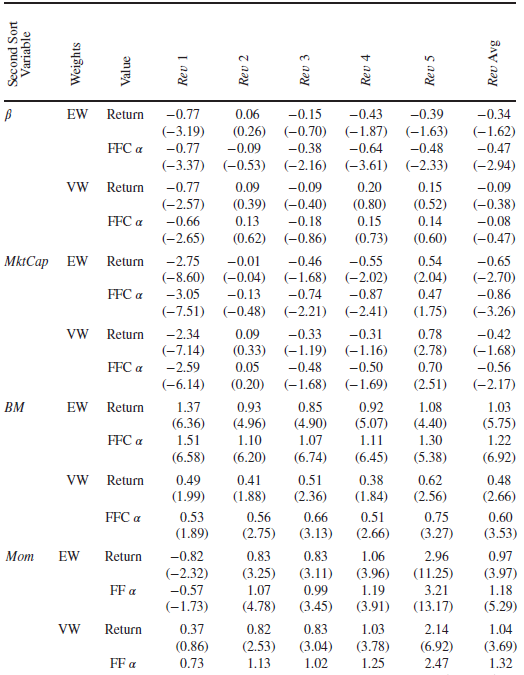

* After controlling for the effect of reversal, the relation between 𝛽 and future stock returns is negative(consistent with Chapter 8) but statistically insignificant.
* The negative relation between MktCap and future stock returns is strong, even after controlling for Rev, weaker in value-weighted portfolios.
* The relation between BM and future stock returns is negative, weaker in value-weighted portfolios.
* A medium-term momentum phenomenon, among stocks with high values of Rev.

### Bivariate Independent-Sort Portfolio Analysis—Control for Rev
* the relation between future stock returns and each of 𝛽, MktCap, BM, and Mom (second sort variables) after controlling for the effect of Rev

In [34]:
# Table9
def Table9fun(other,sort,rt,mkt,ffc):
    # grouping
    X = pd.DataFrame()
    data = pd.merge(other,sort,on=['code','month_num'])
    data = pd.merge(data,rt,on=['code','month_num'])
    if 'mktcap' in data.columns:
        data = data.drop('mktcap',axis=1)
    data = pd.merge(data,mkt,on=['code','month_num'])
    data = data.dropna()
    data['rt_rf*mkt'] = data['rt_rf']*data['mktcap']
    other_name = other.columns[2]
    sort_name = sort.columns[2]
    for i in range(1,240):
        temp_value = data[data['month_num'] == i]
        temp_value['group1'] = pd.qcut(temp_value[other_name],5,labels=False,duplicates='drop')
        temp_value['group2'] = pd.qcut(temp_value[sort_name],5,labels=False,duplicates='drop')
        X = pd.concat([X,temp_value],axis=0)# panel data with group index
    # 求每期每组市场等权均值
    temp_equal = X.groupby(['month_num','group1','group2'])['rt_rf'].mean().reset_index()
    temp_equal = pd.pivot_table(temp_equal,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    temp_equal[5] = (temp_equal[0]+temp_equal[1]+temp_equal[2]+temp_equal[3]+temp_equal[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_equal['month_num'])):
        x = temp_equal[temp_equal['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1)
    df = df.T
    df.index = list(set(temp_equal['month_num']))# df中index为月份，columns为组别
    # 回归与求t
    avg_t = []
    FFCalpha = []
    FFCalpha_t = []
    temp = pd.concat([df,ffc],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML','MOM']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Rev1','Rev2','Rev3','Rev4','Rev5','Rev avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    
    EW = pd.concat([rt_avg,avg_t,FFCalpha,FFCalpha_t],axis=1).T
    EW.index = ['Return',' ','FFC α',' ']    
    # 求每期每组市场加权均值
    temp_weight = (X.groupby(['month_num','group1','group2'])['rt_rf*mkt'].sum()/X.groupby(['month_num','group1','group2'])['mktcap'].sum()).reset_index()
    temp_weight = temp_weight.rename(columns={0:'rt_rf'})
    temp_weight = pd.pivot_table(temp_weight,index = ['month_num','group2'],columns = 'group1')['rt_rf'].reset_index()
    temp_weight[5] = (temp_weight[0]+temp_weight[1]+temp_weight[2]+temp_weight[3]+temp_weight[4])/5
    df = pd.DataFrame()
    for i in list(set(temp_weight['month_num'])):
        x = temp_weight[temp_weight['month_num'] == i].reset_index(drop=True)
        x1 = x.iloc[4,2:]-x.iloc[0,2:]
        df = pd.concat([df,x1],axis=1)
    df = df.T
    df.index = list(set(temp_weight['month_num']))# df中index为月份，columns为组别
    # 回归与求t
    avg_t = []
    FFCalpha = []
    FFCalpha_t = []
    temp = pd.concat([df,ffc],axis=1,join='inner')
    for i in range(6):
        model = sm.OLS(temp[i],[1]*len(temp[i]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        avg_t.append(model.tvalues[0])
        model2 = sm.OLS(temp[i],sm.add_constant(temp.loc[:,['Mkt_RF','SMB','HML','MOM']]), missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':6})
        FFCalpha.append(model2.params[0])
        FFCalpha_t.append(model2.tvalues[0])
    rt_avg = df.mean()
    rt_avg.index = ['Rev1','Rev2','Rev3','Rev4','Rev5','Rev avg']
    avg_t = pd.Series(avg_t,index = rt_avg.index)
    FFCalpha = pd.Series(FFCalpha,index = rt_avg.index)
    FFCalpha_t = pd.Series(FFCalpha_t,index = rt_avg.index)
    VW = pd.concat([rt_avg,avg_t,FFCalpha,FFCalpha_t],axis=1).T
    VW.index = ['Return',' ','FFC α',' ']    
    table = pd.concat([EW,VW],keys=['EW','VW'])
    return table   

In [35]:
rev_beta = Table9fun(Rev2,beta2,rt_rf2,mktcap2,ffc)
rev_mktcap = Table9fun(Rev2,mktcap2,rt_rf2,mktcap2,ffc)
rev_bm = Table9fun(Rev2,bm2,rt_rf2,mktcap2,ffc)
rev_mom = Table9fun(Rev2,Mom2,rt_rf2,mktcap2,ffc)
Table9 = pd.concat([rev_beta,rev_mktcap,rev_bm,rev_mom],keys=['beta','Mktcap','BM','Mom'])
Table9.applymap(lambda x:round(x, 2))

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Rev1  Rev2  Rev3  Rev4  Rev5  Rev avg
beta   EW Return  0.60  0.04 -0.37 -0.67 -1.24    -0.33
                  2.07  0.15 -1.35 -2.34 -3.87    -1.44
          FFC α   0.83  0.10 -0.18 -0.63 -1.01    -0.18
                  2.76  0.36 -0.57 -1.89 -2.71    -0.66
       VW Return  0.48  0.09 -0.39 -0.85 -1.56    -0.45
                  1.20  0.20 -0.85 -1.98 -3.46    -1.31
          FFC α   0.70  0.14 -0.03 -0.78 -1.35    -0.27
                  1.62  0.31 -0.07 -1.58 -2.78    -0.67
Mktcap EW Return -1.83 -1.64 -1.49 -1.23 -1.92    -1.62
                 -4.85 -4.35 -3.96 -3.01 -3.68    -4.36
          FFC α  -1.57 -1.43 -1.27 -1.17 -1.47    -1.39
                 -4.61 -3.85 -3.10 -2.92 -3.17    -3.82
       VW Return -1.82 -1.67 -1.38 -0.95 -1.64    -1.49
                 -4.07 -3.60 -3.05 -1.98 -3.00    -3.43
          FFC α  -1.58 -1.39 -1.16 -0.89 -1.25    -1.26
                 -3.85 -3.08 -2.29 -1.81 -2.40    -2.86
BM     EW Return  0.32  0.45  0.66  0.60  0.49     0.50
                  1.26  1.90  2.60  1.94  1.54     2.23
          FFC α   0.25  0.31  0.73  0.56  0.37     0.44
                  0.90  1.52  2.73  1.72  1.12     1.93
       VW Return  0.19  0.11  0.70  0.78  0.44     0.44
                  0.52  0.33  2.19  1.82  1.08     1.52
          FFC α   0.19 -0.05  0.80  0.79  0.17     0.38
                  0.47 -0.14  2.28  1.69  0.41     1.19
Mom    EW Return -0.22 -0.20  0.17  0.07  0.17    -0.00
                 -0.66 -0.63  0.59  0.20  0.39    -0.01
          FFC α  -0.17 -0.16  0.06  0.14  0.47     0.07
                 -0.49 -0.50  0.20  0.36  1.12     0.21
       VW Return -0.11  0.17  0.34  0.39  0.31     0.22
                 -0.26  0.45  0.85  0.84  0.57     0.59
          FFC α  -0.05  0.24  0.31  0.53  0.80     0.37
                 -0.11  0.62  0.69  1.11  1.66     0.95

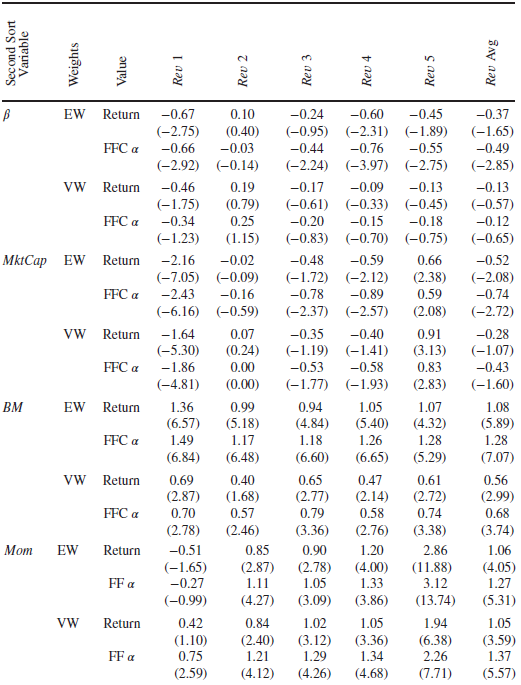

### Fama–MacBeth Regressions
* All independent variables are winsorized at the 0.5% level on amonthly basis.

In [36]:
# Table10-12
Rev1 = Rev.stack()
beta1 = beta.stack()
size1 = size.stack()
bm1 = bm.stack()
Mom1 = Mom.stack()
rt_rf1 = rt_rf.stack()
final = pd.concat([rt_rf1,Rev1,beta1,size1,bm1,Mom1],axis=1, join='inner')
a = final.reset_index()
a.columns = ['code','month_num','rt_rf','Rev','beta','size','bm','Mom']


def FM_regression1(independent):
    coefs = []
    adj_R = []
    number = []
    # 筛选出所需指标数据
    df = a.copy()
    FM_df = df[(['month_num','rt_rf'] + independent)].copy()
    month = FM_df[['month_num']].drop_duplicates()
    for i in month['month_num']:
        temp = FM_df[FM_df['month_num'] == i].copy()        
        temp = temp.dropna()
        number.append(len(temp)) #样本量
        temp = temp.drop(columns = 'month_num')
        temp[independent] = winsorize(temp[independent], limits=(0.005, 0.005))
        Y = temp['rt_rf']
        X = temp[independent]
        model = sm.OLS(Y.values,sm.add_constant(X).values).fit()
        coefs.append(model.params)
        adj_R.append(model.rsquared_adj)
    col = ['intercept']+independent    
    result = pd.DataFrame(
            coefs, 
            index = month['month_num'],
            columns = col
            )
    result['adj_R'] = adj_R
    result['n'] = number
    return result

def NWtest_1sample(a, lags=6):
    adj_a = np.array(a)
    # 对常数回归
    model = sm.OLS(adj_a, [1] * len(adj_a)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return adj_a.mean(), float(model.tvalues)

def Table101112fun(table,name,index,colname):
    temp = pd.DataFrame()    
    for i in range(len(data_list)):
        data = data_list[i]
        value1 = data.iloc[:, :-2].apply(NWtest_1sample)
        value1 = np.array([list(x) for x in value1.values]).reshape(-1)
        value2 = data.iloc[:, -2:].mean().values
        value = pd.DataFrame(list(value1) + list(value2))
        inx = ['Intercept','t0']+index[i]+['Adj_R2','n']
        value.index = inx
        temp = pd.concat([temp,value],axis = 1,join = 'outer')
    temp.columns = name
    df = temp.T
    df = df[colname]
    df = df.T
    return df

### Fama–MacBeth Regressions
* the relation between expected stock returns and reversal
* The reversal phenomenon persists after controlling for each of 𝛽, Size, BM, and Mom.

In [37]:
# Table10
A1  = FM_regression1(['Rev'])
A2  = FM_regression1(['Rev','beta'])
A3  = FM_regression1(['Rev','size'])
A4  = FM_regression1(['Rev','bm'])
A5  = FM_regression1(['Rev','Mom'])
A6  = FM_regression1(['Rev','beta','size','bm','Mom'])
data_list = [A1,A2,A3,A4,A5,A6]
colname=['Rev','Revt0','beta','betat0','size','sizet0','bm','bmt0','Mom','Momt0','Intercept','t0','Adj_R2','n']
data_name = ['(1)','(2)','(3)','(4)','(5)','(6)']
index_name = [['Rev','Revt0'],['Rev','Revt0','beta','betat0'],['Rev','Revt0','size','sizet0'],['Rev','Revt0','bm','bmt0'],['Rev','Revt0','Mom','Momt0'],['Rev','Revt0','beta','betat0','size','sizet0','bm','bmt0','Mom','Momt0']]
Table10 = Table101112fun(data_list,data_name,index_name,colname)
Table10 = Table10.applymap(lambda x:round(x, 3))
Table10.loc['n',:] = Table10.loc['n',:].astype('int')
Table10[Table10.isna()] = ' '
Table10

,(1),(2),(3),(4),(5),(6)
Rev,-0.034,-0.032,-0.04,-0.035,-0.032,-0.033
Revt0,-4.347,-4.031,-5.282,-4.36,-4.276,-4.579
beta,,-0.177,,,,-0.500
betat0,,-0.38,,,,-1.210
size,,,-0.439,,,-0.542
sizet0,,,-2.571,,,-3.682
bm,,,,0.165,,0.102
bmt0,,,,2.444,,2.018
Mom,,,,,0.002,0.004
Momt0,,,,,0.353,0.935


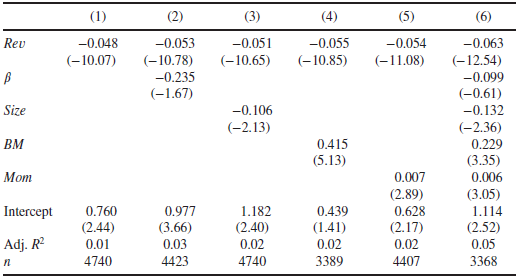

### Fama–MacBeth Regression Analysis—Lagged Values of Reversal
* the relation between expected stock returns and previous values of reversal

In [38]:
# Table11
rt = pd.pivot_table(df,index=['code'],values=['rt'],columns=['month_num'])*100
rt.columns=range(-11,241)
final = pd.concat([rt_rf1,Rev1],axis=1, join='inner')
for i in ['Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11']:
    rt.columns = rt.columns+1
    temp=rt.loc[:,1:241].stack()
    final = pd.concat([final,temp],axis=1, join='inner')
a = final.reset_index()
a.columns = ['code','month_num','rt_rf','Rev','Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11']

A1  = FM_regression1(['Rev'])
A2  = FM_regression1(['Rt-1'])
A3  = FM_regression1(['Rt-2'])
A4  = FM_regression1(['Rt-3'])
A5  = FM_regression1(['Rt-4'])
A6  = FM_regression1(['Rt-5'])
A7  = FM_regression1(['Rt-6'])
A8  = FM_regression1(['Rt-7'])
A9  = FM_regression1(['Rt-8'])
A10  = FM_regression1(['Rt-9'])
A11  = FM_regression1(['Rt-10'])
A12  = FM_regression1(['Rt-11'])
A13  = FM_regression1(['Rev','Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11'])
data_list = [A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13]

colname=['Rev','Revt','Rt-1','Rt-1t','Rt-2','Rt-2t','Rt-3','Rt-3t','Rt-4','Rt-4t','Rt-5','Rt-5t','Rt-6','Rt-6t','Rt-7','Rt-7t','Rt-8','Rt-8t','Rt-9','Rt-9t','Rt-10','Rt-10t','Rt-11','Rt-11t','Intercept','t0','Adj_R2','n']
data_name = ['(1)','(2)','(3)','(4)','(5)','(6)','(7)','(8)','(9)','(10)','(11)','(12)','(13)']
index_name = [['Rev','Revt'],['Rt-1','Rt-1t'],['Rt-2','Rt-2t'],['Rt-3','Rt-3t'],['Rt-4','Rt-4t'],['Rt-5','Rt-5t'],['Rt-6','Rt-6t'],['Rt-7','Rt-7t'],['Rt-8','Rt-8t'],['Rt-9','Rt-9t'],['Rt-10','Rt-10t'],['Rt-11','Rt-11t'],['Rev','Revt','Rt-1','Rt-1t','Rt-2','Rt-2t','Rt-3','Rt-3t','Rt-4','Rt-4t','Rt-5','Rt-5t','Rt-6','Rt-6t','Rt-7','Rt-7t','Rt-8','Rt-8t','Rt-9','Rt-9t','Rt-10','Rt-10t','Rt-11','Rt-11t']]
Table11 = Table101112fun(data_list,data_name,index_name,colname)
Table11 = Table11.applymap(lambda x:round(x, 3))
Table11.loc['n',:] = Table11.loc['n',:].astype('int')
Table11[Table11.isna()] = ' '
Table11

,(1),(2),(3),(4),(5),(6),(7),(8),(9),(10),(11),(12),(13)
Rev,-0.04,,,,,,,,,,,,-0.046
Revt,-4.578,,,,,,,,,,,,-5.332
Rt-1,,-0.024,,,,,,,,,,,-0.022
Rt-1t,,-3.11,,,,,,,,,,,-3.286
Rt-2,,,0.006,,,,,,,,,,0.001
Rt-2t,,,0.534,,,,,,,,,,0.081
Rt-3,,,,0.006,,,,,,,,,0.006
Rt-3t,,,,0.842,,,,,,,,,0.981
Rt-4,,,,,-0.016,,,,,,,,-0.003
Rt-4t,,,,,-1.695,,,,,,,,-0.333


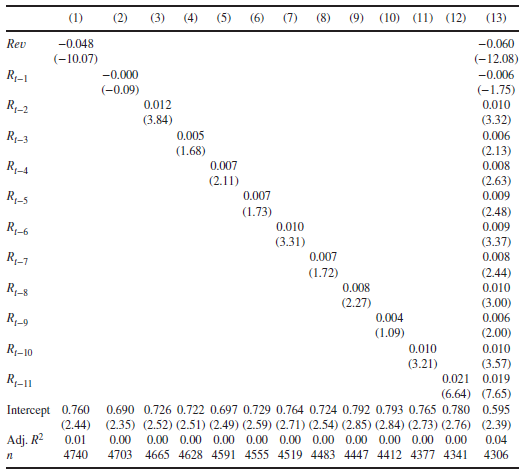

### Fama–MacBeth Regression Analysis—Lagged Values of Reversal with Controls
* the relation between expected stock returns and previous values of reversal

In [39]:
# Table12
final = pd.concat([final,beta1,size1,bm1,Mom1],axis=1, join='inner')
a = final.reset_index()
a.columns = ['code','month_num','rt_rf','Rev','Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11','beta','size','bm','Mom']

A1  = FM_regression1(['Rev','Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11','beta'])
A2  = FM_regression1(['Rev','Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11','size'])
A3  = FM_regression1(['Rev','Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11','bm'])
A4  = FM_regression1(['Rev','Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11','Mom'])
A5  = FM_regression1(['Rev','Rt-1','Rt-2','Rt-3','Rt-4','Rt-5','Rt-6','Rt-7','Rt-8','Rt-9','Rt-10','Rt-11','beta','size','bm','Mom'])
data_list = [A1,A2,A3,A4,A5]

colname=['Rev','Revt','Rt-1','Rt-1t','Rt-2','Rt-2t','Rt-3','Rt-3t','Rt-4','Rt-4t','Rt-5','Rt-5t','Rt-6','Rt-6t','Rt-7','Rt-7t','Rt-8','Rt-8t','Rt-9','Rt-9t','Rt-10','Rt-10t','Rt-11','Rt-11t','beta','betat','size','sizet','bm','bmt','Mom','Momt','Intercept','t0','Adj_R2','n']
data_name = ['(1)','(2)','(3)','(4)','(5)']
index_name = [['Rev','Revt','Rt-1','Rt-1t','Rt-2','Rt-2t','Rt-3','Rt-3t','Rt-4','Rt-4t','Rt-5','Rt-5t','Rt-6','Rt-6t','Rt-7','Rt-7t','Rt-8','Rt-8t','Rt-9','Rt-9t','Rt-10','Rt-10t','Rt-11','Rt-11t','beta','betat'],\
              ['Rev','Revt','Rt-1','Rt-1t','Rt-2','Rt-2t','Rt-3','Rt-3t','Rt-4','Rt-4t','Rt-5','Rt-5t','Rt-6','Rt-6t','Rt-7','Rt-7t','Rt-8','Rt-8t','Rt-9','Rt-9t','Rt-10','Rt-10t','Rt-11','Rt-11t','size','sizet'],\
              ['Rev','Revt','Rt-1','Rt-1t','Rt-2','Rt-2t','Rt-3','Rt-3t','Rt-4','Rt-4t','Rt-5','Rt-5t','Rt-6','Rt-6t','Rt-7','Rt-7t','Rt-8','Rt-8t','Rt-9','Rt-9t','Rt-10','Rt-10t','Rt-11','Rt-11t','bm','bmt'],\
              ['Rev','Revt','Rt-1','Rt-1t','Rt-2','Rt-2t','Rt-3','Rt-3t','Rt-4','Rt-4t','Rt-5','Rt-5t','Rt-6','Rt-6t','Rt-7','Rt-7t','Rt-8','Rt-8t','Rt-9','Rt-9t','Rt-10','Rt-10t','Rt-11','Rt-11t','Mom','Momt'],\
              ['Rev','Revt','Rt-1','Rt-1t','Rt-2','Rt-2t','Rt-3','Rt-3t','Rt-4','Rt-4t','Rt-5','Rt-5t','Rt-6','Rt-6t','Rt-7','Rt-7t','Rt-8','Rt-8t','Rt-9','Rt-9t','Rt-10','Rt-10t','Rt-11','Rt-11t','beta','betat','size','sizet','bm','bmt','Mom','Momt']]
Table12 = Table101112fun(data_list,data_name,index_name,colname)
Table12 = Table12.applymap(lambda x:round(x, 3))
Table12.loc['n',:] = Table12.loc['n',:].astype('int')
Table12[Table12.isna()] = ' '
Table12

,(1),(2),(3),(4),(5)
Rev,-0.044,-0.048,-0.045,-0.044,-0.044
Revt,-5.31,-5.969,-5.268,-5.134,-5.535
Rt-1,-0.023,-0.022,-0.022,-0.033,-0.028
Rt-1t,-3.326,-3.279,-3.187,-4.663,-4.163
Rt-2,0.002,0.003,0.001,-0.011,-0.004
Rt-2t,0.215,0.418,0.167,-1.469,-0.588
Rt-3,0.005,0.009,0.007,-0.006,-0.000
Rt-3t,0.854,1.536,1.175,-1.012,-0.063
Rt-4,-0.001,-0.002,-0.002,-0.015,-0.010
Rt-4t,-0.185,-0.284,-0.266,-1.911,-1.429


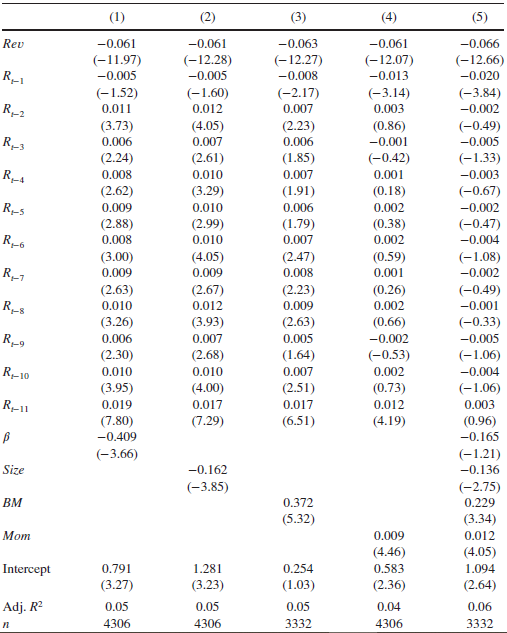

### The Reversal Factor
* Each month, all stocks are sorted into two groups based on market capitalization, with the breakpoint being the median market capitalization of all stocks. The same set of stocks is broken into three groups based on reversal, with the breakpoints being the 30th and 70th percentiles of Rev. Six value-weighted portfolios are then formed.
* STR, short-term reversal, is taken to be the average one-month-ahead future return of the two low-reversal portfolios minus the average one-month-ahead future return of the two high-reversal portfolios.

In [40]:
# Figure1
df['rt'] = df.groupby(['code'])['rt'].shift(-1)
alldata = df[(df.date < '2020-1-1') & (df.date > '1999-12-31')]

def get_decile(data,x1_name,x2_name):
    x1 = data.groupby(['date'])[x1_name].describe(percentiles=[0.3, 0.7]).reset_index() 
    x1 = x1[['date','30%','70%']]
    x2 = data.groupby(['date'])[x2_name].describe(percentiles=[0.5]).reset_index()
    x2 = x2[['date','50%']]
    df = pd.merge(x1, x2, how='inner', on=['date'])
    df.columns=['date','B1_1t','B1_2t','B2_1t']   
    return df
decile = get_decile(alldata,'Rev','mktcap')

def portfolio_ind_3x4(breakpoints,X1_name,X2_name):
    data = alldata.copy()
    date = data[['date']].drop_duplicates()
    X = pd.DataFrame()
    for t in date['date']:
        temp_data = data[data['date'] == t]
        temp_breakpoint = breakpoints[breakpoints['date'] == t].iloc[0,:]
        B1 = [-np.inf,temp_breakpoint[1],temp_breakpoint[2],np.inf]
        B2 = [-np.inf,temp_breakpoint[3],np.inf]
        temp = pd.DataFrame()
        for i in range(3):
            x = temp_data[(temp_data[X1_name]>=B1[i])&(temp_data[X1_name]<=B1[i+1])]
            x['Revport'] = X1_name+str(i+1)
            temp = pd.concat([temp,x])
        temp2 = pd.DataFrame()
        for j in range(2):
            x = temp[(temp[X2_name]>=B2[j])&(temp[X2_name]<=B2[j+1])]
            x['mktport'] = X2_name+str(j+1)
            temp2 = pd.concat([temp2,x])
        X = pd.concat([X,temp2])
    return X

class_1 = portfolio_ind_3x4(decile,'Rev','mktcap')

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

vwret=class_1.groupby(['date','mktport','Revport']).apply(wavg,'rt','mktcap').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['port']=vwret['mktport']+vwret['Revport']
factors=vwret.pivot(index='date', columns='port', values='vwret').reset_index()

# create Reversal factors
factors['RH']=(factors['mktcap2Rev3']+factors['mktcap1Rev3'])/2
factors['RL']=(factors['mktcap2Rev1']+factors['mktcap1Rev1'])/2
factors['Reversal'] = factors['RL']-factors['RH']
# create cer and cler
factors['1+rt'] = factors['Reversal']+1
factors['ln1+rt'] = np.log(factors['1+rt'])
factors['cer'] = factors['1+rt'].cumprod()
factors['cler'] = factors['ln1+rt'].cumsum()

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


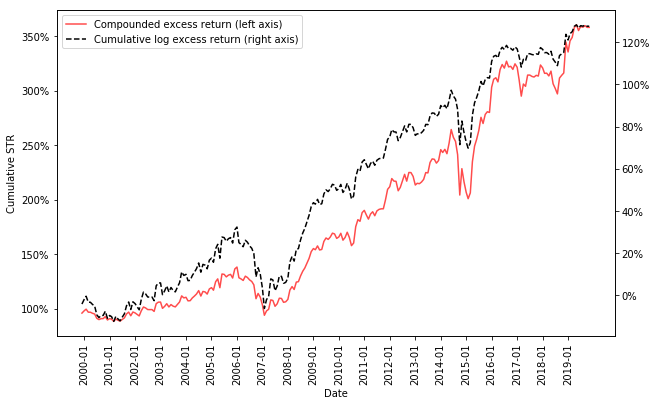

In [41]:
def plot(data,key1,key2):
    data = data.set_index('date')
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(111)
    lns1 = ax1.plot(data[key1]*100, '-',color='r',alpha=0.7, label = 'Compounded excess return (left axis)')
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    lns2 = ax2.plot(data[key2]*100, '--',color='k',label = 'Cumulative log excess return (right axis)')
    lns = lns1+lns2
    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.xticks(pd.date_range('2000-1','2019-12',freq='12M'))#时间间隔
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    fmt='%.0f%%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax1.yaxis.set_major_formatter(yticks)
    ax2.yaxis.set_major_formatter(yticks)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative STR')
    return fig

fig1 = plot(factors,'cer','cler')

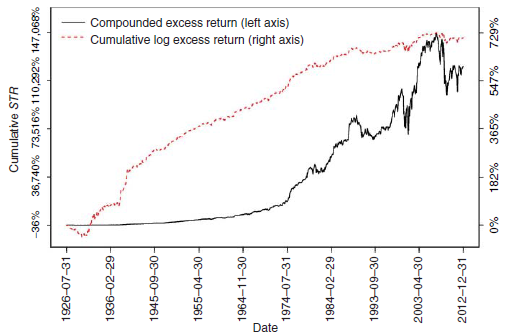